# Problem Statement: We got a dataset of a shopping that contains details of customers with respect to their transactions in the mall, our job is to segment the customers based upon their transactions and submit the report to the stakeholders.

# Importing Necessary Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from charset_normalizer import detect
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
# for dealing with encoded data we use the charset-normalizer package as given above as the given data
# here is encoded, to install this package simply put "pip install charset-normalizer" in the command
# terminal and hit enter.
with open('Shopping-Mall-Data.csv','rb') as f:
    enc=detect(f.read())

# The Raw Data

In [3]:
df=pd.read_csv('Shopping-Mall-Data.csv',encoding=enc['encoding'])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536627,22783,SET 3 WICKER OVAL BASKETS W LIDS,1,12/2/2010 10:53,19.95,15658.0,United Kingdom
1,536627,22941,CHRISTMAS LIGHTS 10 REINDEER,2,12/2/2010 10:53,8.50,15658.0,United Kingdom
2,536627,21756,BATH BUILDING BLOCK WORD,3,12/2/2010 10:53,5.95,15658.0,United Kingdom
3,536627,22961,JAM MAKING SET PRINTED,12,12/2/2010 10:53,1.45,15658.0,United Kingdom
4,536627,22423,REGENCY CAKESTAND 3 TIER,4,12/2/2010 10:53,12.75,15658.0,United Kingdom
...,...,...,...,...,...,...,...,...
75115,556023,22425,ENAMEL COLANDER CREAM,1,6/8/2011 12:21,4.95,14527.0,United Kingdom
75116,556023,23182,TOILET SIGN OCCUPIED OR VACANT,4,6/8/2011 12:21,0.83,14527.0,United Kingdom
75117,556023,82580,BATHROOM METAL SIGN,4,6/8/2011 12:21,0.55,14527.0,United Kingdom
75118,556023,22672,FRENCH BATHROOM SIGN BLUE METAL,4,6/8/2011 12:21,1.65,14527.0,United Kingdom


In [4]:
# the no. of rows and columns in the data
print(df.shape)

(75120, 8)


In [5]:
# checking for null-values
print('Columns with Null values:\n')
print(df.isnull().any())
print('-----'*5+'\n')
print('Frequency of Null values in each of the columns:\n')
print(df.isnull().sum())

Columns with Null values:

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool
-------------------------

Frequency of Null values in each of the columns:

InvoiceNo          0
StockCode          0
Description      205
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     26908
Country            0
dtype: int64


In [6]:
# we see their are lot of null values in "CustomerID" and few in "Description", but before dealing
# with the null values first we need to handle the duplicate values, even after that if their are null
# values present in our data then we need to take care of them.

In [7]:
# moving ahead, lets check the datatype of every feature
print(df.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [8]:
# we see that "InvoiceDate" feature is in object datatype format, which we need to convert to datetime
# format as that is the correct datatype of "InvoiceDate".
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [9]:
for n in df.columns:
    print(str(n)+':\n')
    print(df[str(n)].value_counts())
    print('-----------'*5+'\n')

InvoiceNo:

537666     536
539437     518
539958     512
540551     502
539434     462
          ... 
540563       1
540560       1
C540559      1
C543605      1
542132       1
Name: InvoiceNo, Length: 3477, dtype: int64
-------------------------------------------------------

StockCode:

85123A    395
22423     377
22720     334
22469     305
85099B    290
         ... 
79063C      1
16010       1
82605       1
84723       1
21369       1
Name: StockCode, Length: 3160, dtype: int64
-------------------------------------------------------

Description:

WHITE HANGING HEART T-LIGHT HOLDER    402
REGENCY CAKESTAND 3 TIER              377
SET OF 3 CAKE TINS PANTRY DESIGN      334
HEART OF WICKER SMALL                 305
JUMBO BAG RED RETROSPOT               290
                                     ... 
COLOURFUL FLOWER FRUIT BOWL             1
VINTAGE BEAD PINK SHADE                 1
TABLE LAMP WHITE SHADE WOOD BASE        1
PINK DISCO HANDBAG                      1
BILI NUT AND WOOD NEC

In [10]:
# at this point lets just drop the insignificant features from our data
df1=df.drop(['Description','StockCode'],axis='columns')
df1

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536627,1,2010-12-02 10:53:00,19.95,15658.0,United Kingdom
1,536627,2,2010-12-02 10:53:00,8.50,15658.0,United Kingdom
2,536627,3,2010-12-02 10:53:00,5.95,15658.0,United Kingdom
3,536627,12,2010-12-02 10:53:00,1.45,15658.0,United Kingdom
4,536627,4,2010-12-02 10:53:00,12.75,15658.0,United Kingdom
...,...,...,...,...,...,...
75115,556023,1,2011-06-08 12:21:00,4.95,14527.0,United Kingdom
75116,556023,4,2011-06-08 12:21:00,0.83,14527.0,United Kingdom
75117,556023,4,2011-06-08 12:21:00,0.55,14527.0,United Kingdom
75118,556023,4,2011-06-08 12:21:00,1.65,14527.0,United Kingdom


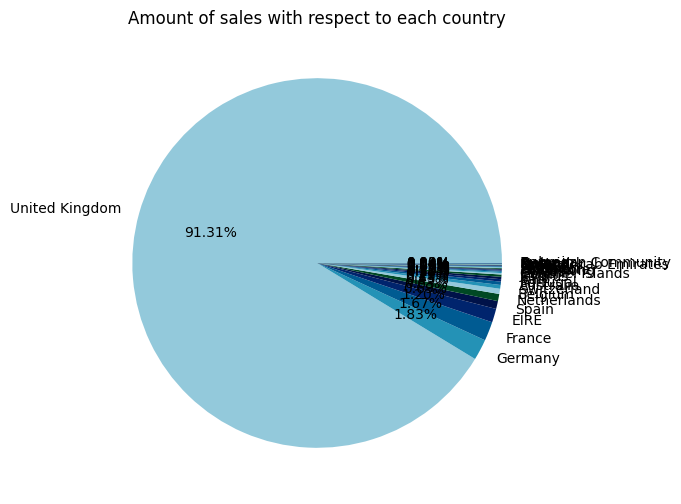

In [11]:
# here each row of the data states one transaction, and the quantity column does not contain any null
# values with that said lets plot a pie chart that states the amount of transactions with respect
# to each country.
plt.figure(figsize=(16,6))
plt.pie(df1['Country'].value_counts(),labels=df1['Country'].value_counts().index,autopct='%0.2f%%',
        colors=sns.color_palette('ocean_r'))
plt.title('Amount of sales with respect to each country')
plt.show()

In [12]:
# from the above pie chart we observe that almost 91% of our transaction originate from united kingdom.
# however the Country column is useless as more than 90% of the data belongs to the same country that
# is United Kingdom hence we have to drop the Country column from the data.
df1.drop(["Country"],axis="columns",inplace=True)

In [13]:
# moving ahead, lets check the min and max values for the numeric columns
for n in df1.columns:
    if df1[str(n)].dtype=='int64' or df1[str(n)].dtype=='float64':
        print(str(n)+':')
        print('max value')
        print(df1[str(n)].max())
        print(('min value'))
        print(df1[str(n)].min())
        print('-------'*5+'\n')

Quantity:
max value
74215
min value
-74215
-----------------------------------

UnitPrice:
max value
16888.02
min value
0.0
-----------------------------------

CustomerID:
max value
18283.0
min value
12346.0
-----------------------------------



In [14]:
# here we see that the quantity column has negative values, we need to tackle this

In [15]:
# rows in quantity column with negative values.
df1[df1['Quantity']<0]

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
276,C536642,-1,2010-12-02 11:56:00,5.95,14390.0
494,C536734,-4,2010-12-02 12:50:00,4.25,16042.0
495,C536734,-1,2010-12-02 12:50:00,7.95,16042.0
502,C536737,-2,2010-12-02 13:05:00,2.95,15922.0
870,C536757,-9360,2010-12-02 14:23:00,0.03,15838.0
...,...,...,...,...,...
75001,556012,-27,2011-06-08 11:45:00,0.00,NaN
75002,C556011,-6,2011-06-08 11:45:00,0.83,14475.0
75003,556013,-17,2011-06-08 11:46:00,0.00,NaN
75004,556014,-3,2011-06-08 11:46:00,0.00,NaN


In [16]:
# no. of rows in quantity column with negative values.
print(len(df1[df1['Quantity']<0]))

1618


In [17]:
# these negative values in quantity most probably be returns hence we hence make we make them 0.
df1['Quantity']=df1['Quantity'].apply(lambda x: 0 if x<0 else x)

In [18]:
# now lets create another column in which we put the total amount of purchase which we could easily
# get by multiplying the quantity with unit price.
# now since we have the total that states the total amount the quantity and unit price column are of
# no use to us hence we drop them.
df1['Total']=df1['Quantity']*df1['UnitPrice']
df1.drop(['Quantity','UnitPrice'],axis='columns',inplace=True)

In [19]:
df1

,InvoiceNo,InvoiceDate,CustomerID,Total
0,536627,2010-12-02 10:53:00,15658.0,19.95
1,536627,2010-12-02 10:53:00,15658.0,17.00
2,536627,2010-12-02 10:53:00,15658.0,17.85
3,536627,2010-12-02 10:53:00,15658.0,17.40
4,536627,2010-12-02 10:53:00,15658.0,51.00
...,...,...,...,...
75115,556023,2011-06-08 12:21:00,14527.0,4.95
75116,556023,2011-06-08 12:21:00,14527.0,3.32
75117,556023,2011-06-08 12:21:00,14527.0,2.20
75118,556023,2011-06-08 12:21:00,14527.0,6.60


In [20]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75120 entries, 0 to 75119
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    75120 non-null  object        
 1   InvoiceDate  75120 non-null  datetime64[ns]
 2   CustomerID   48212 non-null  float64       
 3   Total        75120 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.3+ MB
None


In [21]:
# here everything seems fine except for 'CustomerID' column that contains lot of null values here we
# have no choice but drop these values as the customer id is the unique identifiction of a customer
# there is no way to infer it using any method if not specified as in this case.
df2=df1.dropna()
df2.index=range(len(df2))

In [22]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48212 entries, 0 to 48211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    48212 non-null  object        
 1   InvoiceDate  48212 non-null  datetime64[ns]
 2   CustomerID   48212 non-null  float64       
 3   Total        48212 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.5+ MB
None


In [23]:
# so here we are left with 48212 rows out of earlier 75120 rows after dropping the null values, now all
# the columns in our data are free of null values.

In [24]:
df2

,InvoiceNo,InvoiceDate,CustomerID,Total
0,536627,2010-12-02 10:53:00,15658.0,19.95
1,536627,2010-12-02 10:53:00,15658.0,17.00
2,536627,2010-12-02 10:53:00,15658.0,17.85
3,536627,2010-12-02 10:53:00,15658.0,17.40
4,536627,2010-12-02 10:53:00,15658.0,51.00
...,...,...,...,...
48207,556023,2011-06-08 12:21:00,14527.0,4.95
48208,556023,2011-06-08 12:21:00,14527.0,3.32
48209,556023,2011-06-08 12:21:00,14527.0,2.20
48210,556023,2011-06-08 12:21:00,14527.0,6.60


In [25]:
# now we see multiple duplicate records where the invoice no., invoice date customer id and country is
# same, which states that there are customers that purchased multiple products hence we need to group
# them together and add up the total.
# and a simple approach to do that is by first separating the "invoice no.", and "total" in a separate
# dataframe, lets name it df3_1, and the "invoice no.", "invoice date", "customer id" and "country"
# in a separate dataframe, and lets name it df3_2,

# and then we would want to group the data on the basis of invoice no.

# so what we do is group df3_1 on the basis of "invoice no." and add the "total" then we are left with
# only unique invoice no. and the corresponding sum of their total, and in df3_2 we drop the duplicate
# "invoice no." records and hence we are left with only unique invoice no. after this we can merge
# these two on the "invoice no." get the final data.

# so lets do it.....

In [26]:
df3_1=df2[["InvoiceNo","Total"]].groupby("InvoiceNo").sum("Total")
df3_1=df3_1.reset_index()

In [27]:
df3_1

,InvoiceNo,Total
0,536627,217.80
1,536628,230.56
2,536629,22.20
3,536630,244.46
4,536631,22.20
...,...,...
2935,C555889,0.00
2936,C555892,0.00
2937,C555908,0.00
2938,C555935,0.00


In [28]:
df3_2=df2.drop(["Total"],axis="columns").drop_duplicates(subset=["InvoiceNo"])

In [29]:
df3_2

,InvoiceNo,InvoiceDate,CustomerID
0,536627,2010-12-02 10:53:00,15658.0
8,536628,2010-12-02 10:54:00,17850.0
24,536629,2010-12-02 10:55:00,17850.0
26,536630,2010-12-02 10:56:00,17850.0
42,536631,2010-12-02 10:58:00,17850.0
...,...,...,...
48134,556019,2011-06-08 12:02:00,18092.0
48141,556020,2011-06-08 12:03:00,13571.0
48161,556021,2011-06-08 12:03:00,12921.0
48183,556022,2011-06-08 12:04:00,12921.0


In [30]:
final_df=pd.merge(df3_1,df3_2,how="inner",on="InvoiceNo")

In [31]:
final_df

,InvoiceNo,Total,InvoiceDate,CustomerID
0,536627,217.80,2010-12-02 10:53:00,15658.0
1,536628,230.56,2010-12-02 10:54:00,17850.0
2,536629,22.20,2010-12-02 10:55:00,17850.0
3,536630,244.46,2010-12-02 10:56:00,17850.0
4,536631,22.20,2010-12-02 10:58:00,17850.0
...,...,...,...,...
2935,C555889,0.00,2011-06-07 16:01:00,13476.0
2936,C555892,0.00,2011-06-07 16:03:00,14227.0
2937,C555908,0.00,2011-06-07 16:08:00,15687.0
2938,C555935,0.00,2011-06-08 09:14:00,12567.0


In [32]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2939
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    2940 non-null   object        
 1   Total        2940 non-null   float64       
 2   InvoiceDate  2940 non-null   datetime64[ns]
 3   CustomerID   2940 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 114.8+ KB


In [33]:
# we suceesfully completed our data processing now the data is ready for analysis and model building
# here we would use RFM (Recency, Frequency and monetary) approach to segment the customers into
# various groups.

# RFM segmentation comes from a marketing technique that is used to rank the customers on the basis of
# recency of the transaction of a customer, frequency of the transaction of a customer and the amount
# of monetary purchase of a customer.

In [34]:
data=final_df
data

,InvoiceNo,Total,InvoiceDate,CustomerID
0,536627,217.80,2010-12-02 10:53:00,15658.0
1,536628,230.56,2010-12-02 10:54:00,17850.0
2,536629,22.20,2010-12-02 10:55:00,17850.0
3,536630,244.46,2010-12-02 10:56:00,17850.0
4,536631,22.20,2010-12-02 10:58:00,17850.0
...,...,...,...,...
2935,C555889,0.00,2011-06-07 16:01:00,13476.0
2936,C555892,0.00,2011-06-07 16:03:00,14227.0
2937,C555908,0.00,2011-06-07 16:08:00,15687.0
2938,C555935,0.00,2011-06-08 09:14:00,12567.0


In [35]:
# lets check the most recent and the oldest date of purchase
print(f"Most Recent: {max(data['InvoiceDate'])}\nOldest: {min(data['InvoiceDate'])}")

Most Recent: 2011-06-08 12:21:00
Oldest: 2010-12-02 10:53:00


In [36]:
# now we can see duplicate records in "CustomerId" column, "CustomerId" states an unique
# identification of a customer that means same customers purchased multiple products so lets
# aggregate the data on the basis of "CustomerId", where we take the sum of "Total" aggregated on the
# basis of "CustomerId" to get the total monetary value of an unique customer, then we take the count
# of "InvoiceNo" again aggregated on the basis of "CustomerId" which will tell us the frequency
# of purchase of various products by each unique customer and finally we take the difference of the
# most recent date of purchase and the latest purchase of each customer from "InvoiceDate" aggregated
# again on the basis of "CustomerId" to get the recency values for each customer.

In [37]:
# now to do this we first group the data on the basis of customer id, then we use agg() method and
# use a dictionary to specify how do we want to aggregate each of the columns.
RFM=data.groupby("CustomerID").agg({
    "Total":lambda x: sum(x),
    "InvoiceNo":lambda x: x.count(),
    "InvoiceDate":lambda x: max(df["InvoiceDate"])-max(x)})

In [38]:
RFM

,Total,InvoiceNo,InvoiceDate
CustomerID,,,
12346.0,77183.60,2,141 days 02:04:00
12347.0,475.39,1,132 days 21:51:00
12348.0,1120.24,2,134 days 01:39:00
12350.0,334.40,1,125 days 20:20:00
12352.0,1281.15,5,98 days 20:29:00
...,...,...,...
18257.0,328.40,1,111 days 21:08:00
18260.0,787.77,3,137 days 19:17:00
18269.0,0.00,1,173 days 20:42:00


In [39]:
# now lets quickly rename the columns, reset the index and extract the days from the invoice date.

In [40]:
RFM.reset_index(inplace=True)

In [41]:
RFM.rename(columns={"Total":"Monetary","InvoiceNo":"Frequency","InvoiceDate":"Recency"},inplace=True)

In [42]:
RFM["Recency"]=RFM["Recency"].apply(lambda x: x.days)

In [43]:
RFM

,CustomerID,Monetary,Frequency,Recency
0,12346.0,77183.60,2,141
1,12347.0,475.39,1,132
2,12348.0,1120.24,2,134
3,12350.0,334.40,1,125
4,12352.0,1281.15,5,98
...,...,...,...,...
1423,18257.0,328.40,1,111
1424,18260.0,787.77,3,137
1425,18269.0,0.00,1,173
1426,18277.0,0.00,1,133


In [44]:
# so this is our final clean data on which we further continue our work upon
# lets run some analysis on it.

In [45]:
RFM.describe()[["Monetary","Frequency","Recency"]]

,Monetary,Frequency,Recency
count,1428.000000,1428.000000,1428.000000
mean,829.521583,2.058824,114.872549
std,3219.424761,2.259459,47.920402
min,0.000000,1.000000,0.000000
25%,181.337500,1.000000,110.000000
50%,340.605000,1.000000,125.000000
75%,717.030000,2.000000,141.000000
max,77183.600000,31.000000,188.000000


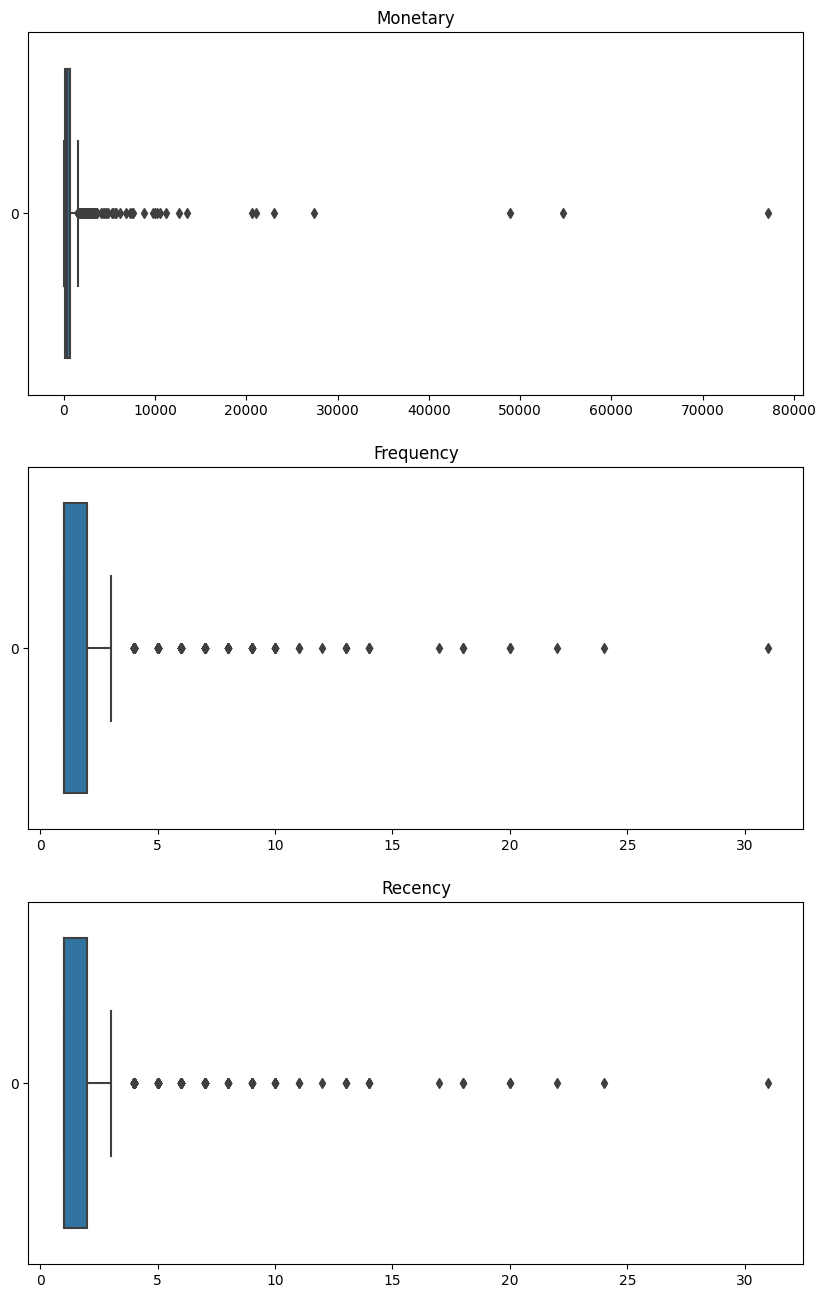

In [46]:
plt.figure(figsize=(10,16))
plt.subplot(3,1,1)
sns.boxplot(RFM["Monetary"],orient="h")
plt.title("Monetary")
plt.subplot(3,1,2)
sns.boxplot(RFM["Frequency"],orient="h")
plt.title("Frequency")
plt.subplot(3,1,3)
sns.boxplot(RFM["Frequency"],orient="h")
plt.title("Recency")
plt.show()

In [47]:
# now lets start with the main RFM process that is grouping the customers based upon their Recency,
# Frequency and Monetary, now how do we do so....
# what we can do is that we can assign scores to the customers Recency, Frequency and Monetary values
# based upon the percentile they lie on, and we divide the percentiles into 4 parts so we can take the
# scoring range as 0 to 3 where 0,1,2 and 3 are the scores that will be assigned.

# now talking about Recency the least the Recency the better the customer, so if the customer lies
# below or equal to 25th percentile then we score them as 3, while if they lie below 50th percentile
# meaning above 25th percentile and below or equal to 50th percentile then we score them as 2,
# similarly if they lie below 75th percentile meaning above 50th percentile and below or equal to 75th
# percentile then we score them as 1, and finally if they lie above 75th percentile we score them as 0.

# this brings us to Frequency where the more the frequency the better the customer, so if the customer
# lies below or equal to 25th percentile then we score them as 0, while if they lie below 50th
# percentile meaning above 25th percentile and below or equal to 50th percentile then we score them as
# 1, similarly if they lie below 75th percentile meaning above 50th percentile and below or equal to
# 75th percentile then we score them as 2, and finally if they lie above 75th percentile we score them
# as 3.

# and lastly we have Monetary where just like Frequency the more it is the better, so here also if the
# customer lies below or equal to 25th percentile then we score them as 0, while if they lie below
# 50th percentile meaning above 25th percentile and below or equal to 50th percentile then we score
# them as 1, similarly if they lie below 75th percentile meaning above 50th percentile and below or
# equal to 75th percentile then we score them as 2, and finally if they lie above 75th percentile we
# score them as 3.

In [48]:
# so lets execute this in our data....
def R_scoring(x):
    if x<=RFM["Recency"].quantile(0.25):
        return 3
    elif x<=RFM["Recency"].quantile(0.50):
        return 2
    elif x<=RFM["Recency"].quantile(0.75):
        return 1
    else:
        return 0

def F_scoring(x):
    if x<=RFM["Frequency"].quantile(0.25):
        return 0
    elif x<=RFM["Frequency"].quantile(0.50):
        return 1
    elif x<=RFM["Frequency"].quantile(0.75):
        return 2
    else:
        return 3
    
def M_scoring(x):
    if x<=RFM["Monetary"].quantile(0.25):
        return 0
    elif x<=RFM["Monetary"].quantile(0.50):
        return 1
    elif x<=RFM["Monetary"].quantile(0.75):
        return 2
    else:
        return 3
RFM["R_score"]=RFM["Recency"].apply(R_scoring)
RFM["F_score"]=RFM["Frequency"].apply(F_scoring)
RFM["M_score"]=RFM["Monetary"].apply(M_scoring)

In [49]:
RFM

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score
0,12346.0,77183.60,2,141,1,2,3
1,12347.0,475.39,1,132,1,0,2
2,12348.0,1120.24,2,134,1,2,3
3,12350.0,334.40,1,125,2,0,1
4,12352.0,1281.15,5,98,3,3,3
...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1
1424,18260.0,787.77,3,137,1,3,3
1425,18269.0,0.00,1,173,0,0,0
1426,18277.0,0.00,1,133,1,0,0


In [50]:
# now lets add these scores to get final scores and the range of these values would be between 0 and 9,
# and more the Final_score of a customer the better the customer is.
# similarly we can also group the customers based upon their individual RFM scores, that is why we
# also add RFM_id column.
RFM["Final_score"]=RFM["R_score"]+RFM["F_score"]+RFM["M_score"]
RFM["RFM_id"]=RFM["R_score"].apply(str)+RFM["F_score"].apply(str)+RFM["M_score"].apply(str)

In [51]:
RFM

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score,Final_score,RFM_id
0,12346.0,77183.60,2,141,1,2,3,6,123
1,12347.0,475.39,1,132,1,0,2,3,102
2,12348.0,1120.24,2,134,1,2,3,6,123
3,12350.0,334.40,1,125,2,0,1,3,201
4,12352.0,1281.15,5,98,3,3,3,9,333
...,...,...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1,3,201
1424,18260.0,787.77,3,137,1,3,3,7,133
1425,18269.0,0.00,1,173,0,0,0,0,000
1426,18277.0,0.00,1,133,1,0,0,1,100


In [52]:
# now first lets group the customers based upon their final_score.....
print(RFM["Final_score"].value_counts().sort_index())

0    112
1    166
2    190
3    215
4    149
5    146
6    114
7    125
8    110
9    101
Name: Final_score, dtype: int64


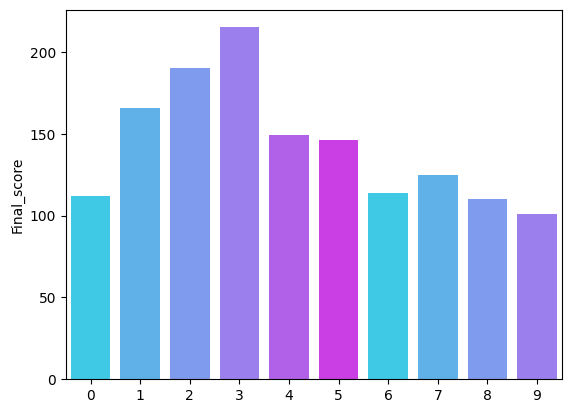

In [53]:
sns.barplot(x=RFM["Final_score"].value_counts().index,
            y=RFM["Final_score"].value_counts(),palette=sns.color_palette("cool"))
plt.show()

In [54]:
# here we group scores 0,1 as bronze, then 2,3 as silver, 4,5 as gold, 6,7 as platinum and 8,9 as
# diamond.
def loyalty(x):
    if x<=1:
        return "Bronze"
    elif x<=3:
        return "Silver"
    elif x<=5:
        return "Gold"
    elif x<=7:
        return "Platinum"
    else:
        return "Diamond"
RFM["Loyalty"]=RFM["Final_score"].apply(loyalty)

In [55]:
RFM

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score,Final_score,RFM_id,Loyalty
0,12346.0,77183.60,2,141,1,2,3,6,123,Platinum
1,12347.0,475.39,1,132,1,0,2,3,102,Silver
2,12348.0,1120.24,2,134,1,2,3,6,123,Platinum
3,12350.0,334.40,1,125,2,0,1,3,201,Silver
4,12352.0,1281.15,5,98,3,3,3,9,333,Diamond
...,...,...,...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1,3,201,Silver
1424,18260.0,787.77,3,137,1,3,3,7,133,Platinum
1425,18269.0,0.00,1,173,0,0,0,0,000,Bronze
1426,18277.0,0.00,1,133,1,0,0,1,100,Bronze


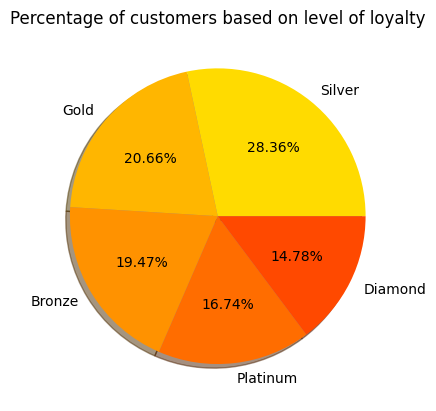

In [56]:
plt.pie(RFM["Loyalty"].value_counts(),
        labels=RFM["Loyalty"].value_counts().index,
        autopct="%0.2f%%",
       colors=sns.color_palette("autumn_r"),
       shadow=True)
plt.title("Percentage of customers based on level of loyalty")
plt.show()

In [57]:
RFM

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score,Final_score,RFM_id,Loyalty
0,12346.0,77183.60,2,141,1,2,3,6,123,Platinum
1,12347.0,475.39,1,132,1,0,2,3,102,Silver
2,12348.0,1120.24,2,134,1,2,3,6,123,Platinum
3,12350.0,334.40,1,125,2,0,1,3,201,Silver
4,12352.0,1281.15,5,98,3,3,3,9,333,Diamond
...,...,...,...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1,3,201,Silver
1424,18260.0,787.77,3,137,1,3,3,7,133,Platinum
1425,18269.0,0.00,1,173,0,0,0,0,000,Bronze
1426,18277.0,0.00,1,133,1,0,0,1,100,Bronze


In [58]:
# here we successfully segmented the data based upon each customers final_score which is nothing but
# the sum of R_score, F_score and M_score hence now we export this data and send it to the appropriate
# user who wants to make use of this segmentation.
RFM[["CustomerID","Loyalty"]].to_csv("c:/users/lenovo/desktop/RFM_sum_seg.csv")

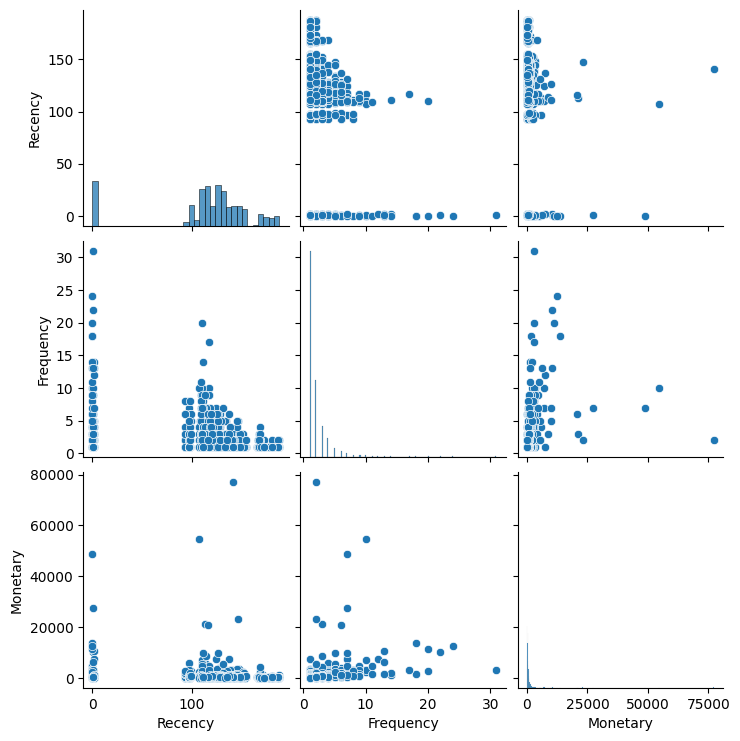

In [59]:
sns.pairplot(RFM[["Recency","Frequency","Monetary"]])
plt.show()

In [60]:
# here we can clearly notice the groups present in the data, so lets perform a proper bivariate
# analysis

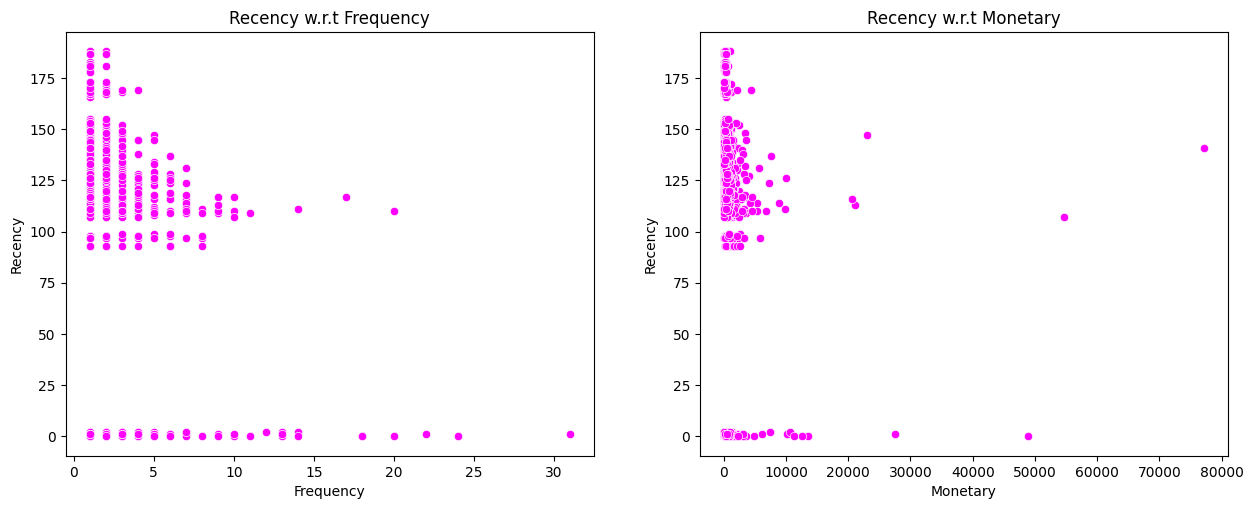

In [61]:
plt.figure(figsize=(15,5.5))
plt.subplot(1,2,1)
sns.scatterplot(x=RFM["Frequency"],y=RFM["Recency"],color="magenta")
plt.title("Recency w.r.t Frequency")
plt.subplot(1,2,2)
sns.scatterplot(x=RFM["Monetary"],y=RFM["Recency"],color="magenta")
plt.title("Recency w.r.t Monetary")
plt.show()

In [62]:
# Insight 1:
# we see the bulk of the purchase is approximately 90 or more days later and the frequency and monetary
# are also quite low for all of this data which is not really a good indication, sure a few outliers
# are here and there but again the bulk of the data is unfavourable so subsequent steps shall be
# taken to improve from this state.

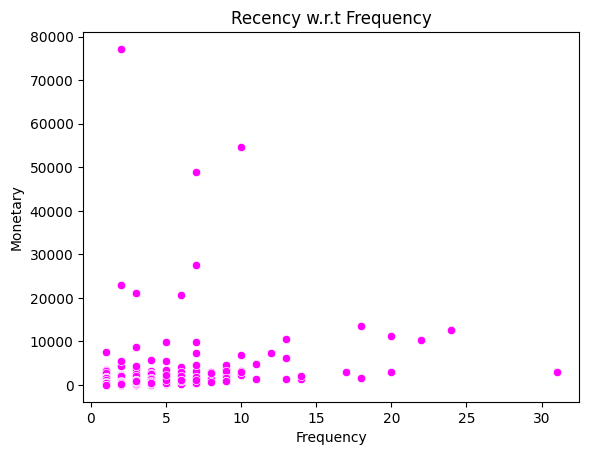

In [63]:
sns.scatterplot(x=RFM["Frequency"],y=RFM["Monetary"],color="magenta")
plt.title("Recency w.r.t Frequency")
plt.show()

In [64]:
# Insight 2:
# here also we do not see anything better as the bulk of the data has very low monetary and frequency
# value except for a few outliers here and there.

In [65]:
# lets do a detailed segmentation on RFM_id to know various types of customers
print(RFM["RFM_id"].value_counts())
print()
print("no. of unique RFM_id:",len(RFM["RFM_id"].value_counts()))

000    112
333    101
001     93
100     73
300     68
101     65
200     63
233     63
201     54
002     52
102     46
301     44
302     37
122     36
202     36
232     32
322     32
332     31
223     31
222     30
133     25
103     24
121     24
123     23
221     22
003     20
303     18
023     16
323     16
203     15
021     15
321     14
231     12
132     11
120     11
022     10
020     10
320      9
220      8
131      6
033      5
331      5
032      4
031      3
230      1
030      1
330      1
Name: RFM_id, dtype: int64

no. of unique RFM_id: 47


In [66]:
# here we see we have 47 different values for RFM_id hence we will be groupimg the customers into few
# groups.
seg_map={
    r"[0-1][0-1][0-1]":"inactive_customer",
    r"[0-1][0-1][2-3]":"high_monetary",

    r"[0-1][2-3][2-3]":"loyal_customers_with_high_monetary",
    r"[2-3][0-1][0-1]":"new_customers",
    
    r"[0-1][2-3][0-1]":"loyal_customers_with_low_recency_&_monetary",

    r"[2-3][2-3][0-1]":"loyal_customers_with_high_recency",
    r"[2-3][0-1][2-3]":"new_customers_with_high_monetary",
    r"[2-3][2-3][2-3]":"most_important_customers",
}
RFM["Segment"]=RFM["RFM_id"].replace(seg_map,regex=True)

In [67]:
RFM

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score,Final_score,RFM_id,Loyalty,Segment
0,12346.0,77183.60,2,141,1,2,3,6,123,Platinum,loyal_customers_with_high_monetary
1,12347.0,475.39,1,132,1,0,2,3,102,Silver,high_monetary
2,12348.0,1120.24,2,134,1,2,3,6,123,Platinum,loyal_customers_with_high_monetary
3,12350.0,334.40,1,125,2,0,1,3,201,Silver,new_customers
4,12352.0,1281.15,5,98,3,3,3,9,333,Diamond,most_important_customers
...,...,...,...,...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1,3,201,Silver,new_customers
1424,18260.0,787.77,3,137,1,3,3,7,133,Platinum,loyal_customers_with_high_monetary
1425,18269.0,0.00,1,173,0,0,0,0,000,Bronze,inactive_customer
1426,18277.0,0.00,1,133,1,0,0,1,100,Bronze,inactive_customer


In [68]:
print(RFM["Segment"].value_counts())

inactive_customer                              343
most_important_customers                       336
new_customers                                  229
high_monetary                                  142
loyal_customers_with_high_monetary             130
new_customers_with_high_monetary               106
loyal_customers_with_high_recency               72
loyal_customers_with_low_recency_&_monetary     70
Name: Segment, dtype: int64


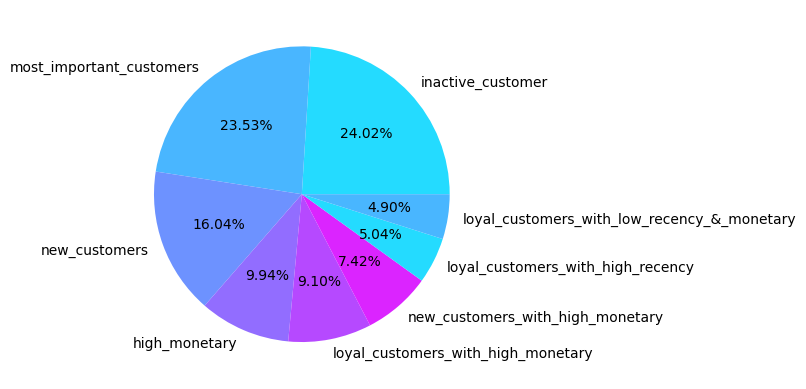

In [69]:
plt.pie(RFM["Segment"].value_counts(),labels=RFM["Segment"].value_counts().index,autopct="%0.2f%%",colors=sns.color_palette("cool"))
plt.show()

In [70]:
# insight 3:-
# we see here that we have 24% inactive customers while we have a similar percentage of most important
# customers and these two contain the bulk of all the customers.
# we also see we have around 16% of new customers and 7% of new customers with high monetary these
# customers are very essential for the business and hence efforts shall be made to retain and convert
# them into loyal customers.
# similarly we have got around 10% of customers with high monetary but low recency and frequncy and
# which states their high will to spend but are somehow not frequent or recent so steps shall be taken
# to increase their recency and frequency.
# then we have got 9% of loyal customers with high monetary but have not purchased recently, 5% of
# loyal customers with high recency but low monetary transaction to these customers high monetary
# products must promoted.
# we also have 5% of loyal customers who have low recency and frequency that need to be accordingly
# catered for, so as to increase their monetary and recency value.

In [71]:
# here we segmented each customer based upon their individual frequency R,F and M Score hence we have
# to export this and send this to the appropriate user of this segmentation.
RFM[["CustomerID","Segment"]].to_csv("c:/users/lenovo/desktop/RFM_id_seg.csv")

In [72]:
# now lets see how will the machine segment this data, for that we will feed the data to a k-means
# clustering algorithm.

In [73]:
# firstly we would only require monetary, frequency and recency for clustering so we keep them and
# drop rest
data1=RFM[["Recency","Frequency","Monetary"]]
# here we have outliers and the data also does nots seem to be normally distributed 
# so we first standardize our model
scaler=StandardScaler()
standardized_array=scaler.fit_transform(data1)
standardized_df=pd.DataFrame(standardized_array,columns=data1.columns)
data2=pd.concat([RFM[["CustomerID"]],standardized_df],axis="columns")

In [74]:
data2

,CustomerID,Recency,Frequency,Monetary
0,12346.0,0.545417,-0.026043,23.724992
1,12347.0,0.357540,-0.468782,-0.110037
2,12348.0,0.399290,-0.026043,0.090333
3,12350.0,0.211413,-0.468782,-0.153846
4,12352.0,-0.352219,1.302173,0.140331
...,...,...,...,...
1423,18257.0,-0.080840,-0.468782,-0.155710
1424,18260.0,0.461916,0.416695,-0.012973
1425,18269.0,1.213425,-0.468782,-0.257752
1426,18277.0,0.378415,-0.468782,-0.257752


In [75]:
# now lets plot an elbow plot to get the optimum no. of centroids or the optimum no. of clusters now
# elbow plot will plot the no. of centroids in x-axis and the sum of squared error of all the
# centroid on the y-axis.

In [76]:
warnings.filterwarnings("ignore")
k_values=range(2,50)
sss=[]
for n in k_values:
    km=KMeans(n_clusters=n)
    km.fit(data2[["Recency","Frequency","Monetary"]])
    sss.append(km.inertia_)

In [77]:
print("Sum of squared errors for various no. of centroids:")
for a,b in zip(k_values,sss):
    print(f"{a}:- {b}")

Sum of squared errors for various no. of centroids:
2:- 2965.4793014400975
3:- 1977.134992128998
4:- 1270.6330355284529
5:- 955.9457692817354
6:- 786.3899125814534
7:- 619.7758588709446
8:- 512.4430376918099
9:- 446.9108007737919
10:- 402.07325770755233
11:- 346.57137366788965
12:- 300.3242490791971
13:- 276.27368597558933
14:- 251.0904288959501
15:- 233.10661359625095
16:- 209.8970634215347
17:- 192.86561506342665
18:- 180.94305900579948
19:- 162.7756665565553
20:- 153.9879399911462
21:- 145.53552406455182
22:- 135.01380334303133
23:- 127.08759650078306
24:- 118.89212415041555
25:- 110.1115605163197
26:- 108.22258730036208
27:- 102.40943549661705
28:- 98.26986180576124
29:- 91.44074448453
30:- 89.51423535671206
31:- 83.90269388835617
32:- 81.80270217006209
33:- 77.51213960399825
34:- 73.74525721081957
35:- 70.85212907414835
36:- 68.7328169223556
37:- 66.20062917909365
38:- 63.99536478940149
39:- 61.732279939924325
40:- 59.35325011361013
41:- 57.46250844762891
42:- 54.14616136319508
43

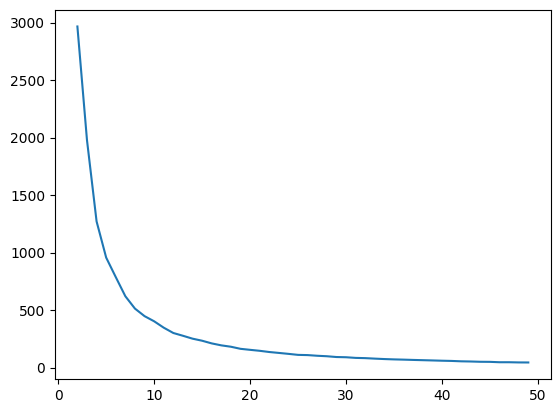

In [78]:
plt.plot(k_values,sss)
plt.show()

In [79]:
# we can see the elbow at around 10 hence we take 10 clusters

In [80]:
kmeans=KMeans(n_clusters=10)
clusters=pd.Series(kmeans.fit_predict(data2[["Recency","Frequency","Monetary"]]),name="Cluster")

In [81]:
# lets checkout the cluster centroids
print(kmeans.cluster_centers_)

[[ 0.95649886 -0.40459822 -0.15557939]
 [ 0.07698563  0.64292999  0.0813501 ]
 [-1.28116723  2.85175867 15.8230637 ]
 [-2.0446049   4.36972023  0.82252628]
 [-2.38253479  0.04961444 -0.08275409]
 [ 0.12973132 -0.32425452 -0.12031547]
 [-0.04187329  2.19748912  0.50034497]
 [-0.43050084  1.08080351  6.90538855]
 [-2.06398906  8.76548391  2.18361025]
 [ 0.54541704 -0.02604346 23.72499212]]


In [82]:
# lets concatenate the cluster that are defined to data
data3=pd.concat([RFM,clusters],axis="columns")

In [83]:
data3

,CustomerID,Monetary,Frequency,Recency,R_score,F_score,M_score,Final_score,RFM_id,Loyalty,Segment,Cluster
0,12346.0,77183.60,2,141,1,2,3,6,123,Platinum,loyal_customers_with_high_monetary,9
1,12347.0,475.39,1,132,1,0,2,3,102,Silver,high_monetary,5
2,12348.0,1120.24,2,134,1,2,3,6,123,Platinum,loyal_customers_with_high_monetary,5
3,12350.0,334.40,1,125,2,0,1,3,201,Silver,new_customers,5
4,12352.0,1281.15,5,98,3,3,3,9,333,Diamond,most_important_customers,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1423,18257.0,328.40,1,111,2,0,1,3,201,Silver,new_customers,5
1424,18260.0,787.77,3,137,1,3,3,7,133,Platinum,loyal_customers_with_high_monetary,1
1425,18269.0,0.00,1,173,0,0,0,0,000,Bronze,inactive_customer,0
1426,18277.0,0.00,1,133,1,0,0,1,100,Bronze,inactive_customer,5


In [84]:
data4=data3.groupby("Cluster").aggregate({
    "CustomerID":lambda x: x.count(),
    "Recency":lambda x: x.mean(),
    "Frequency":lambda x: x.mean(),
    "Monetary":lambda x: x.mean()
})

data4.rename(columns={"CustomerID":"no. of customers",
                      "Recency":"average_recency",
                      "Frequency":"average_frequency",
                     "Monetary":"average_monetary"})
# Average Recency, Frequency and Monetary value of each cluster

,no. of customers,average_recency,average_frequency,average_monetary
Cluster,,,,
0,338,160.692308,1.144970,328.820858
1,182,118.560440,3.510989,1091.330385
2,2,53.500000,8.500000,51752.845000
3,14,16.928571,11.928571,3476.655714
4,158,0.740506,2.170886,563.194304
5,677,121.087149,1.326440,442.310620
6,45,112.866667,7.022222,2439.780444
7,4,94.250000,4.500000,23053.115000
8,7,16.000000,21.857143,7857.028571


In [85]:
data5=data3.groupby("Cluster")

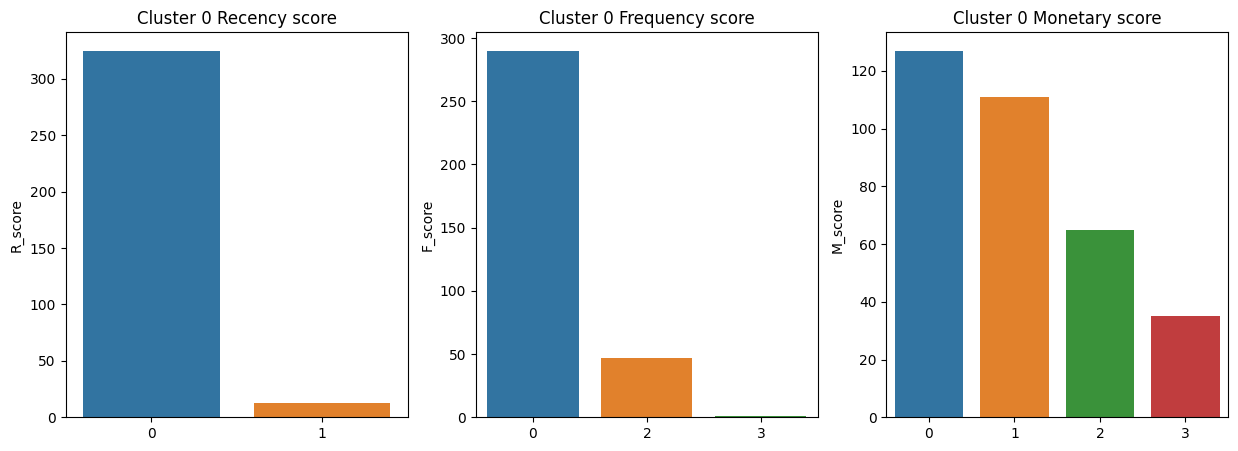

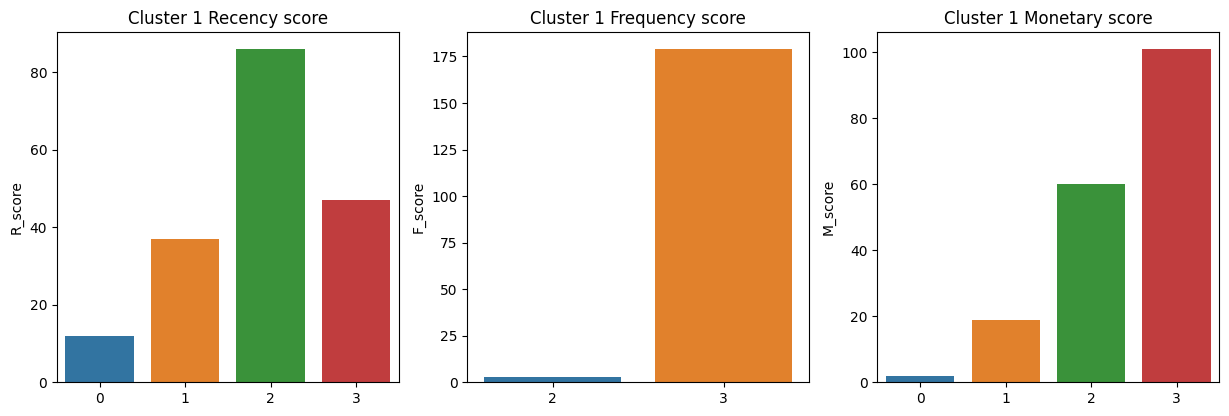

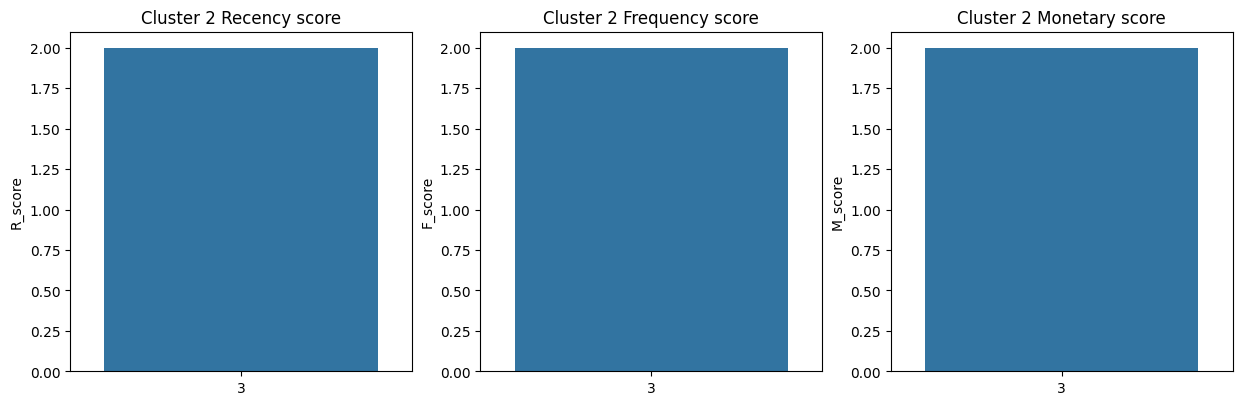

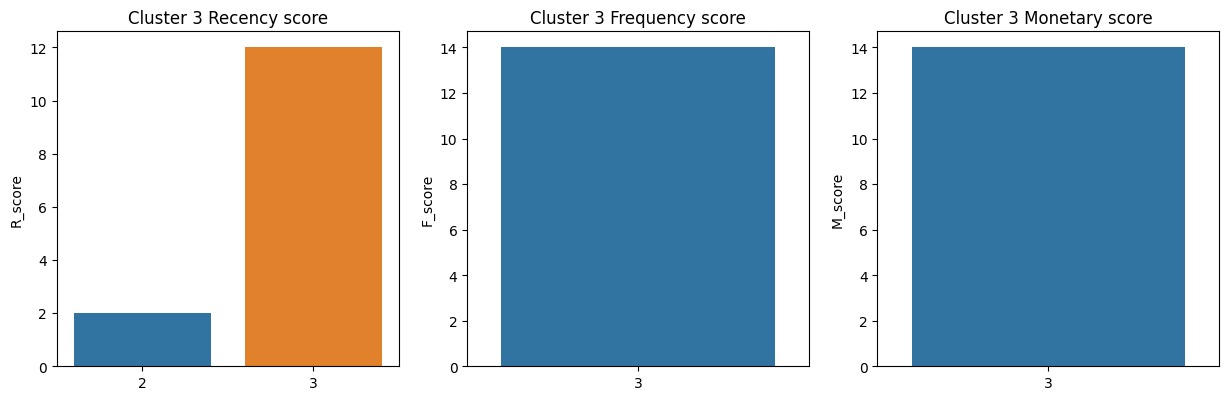

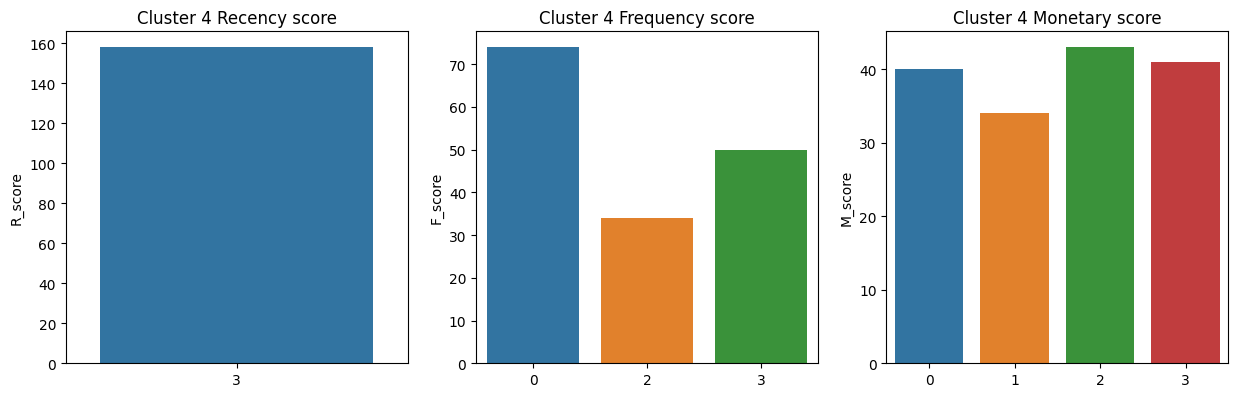

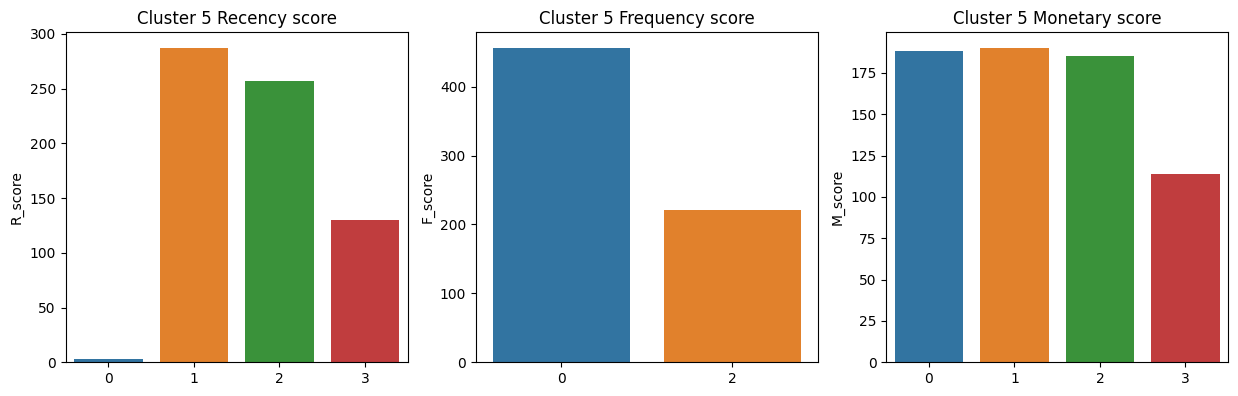

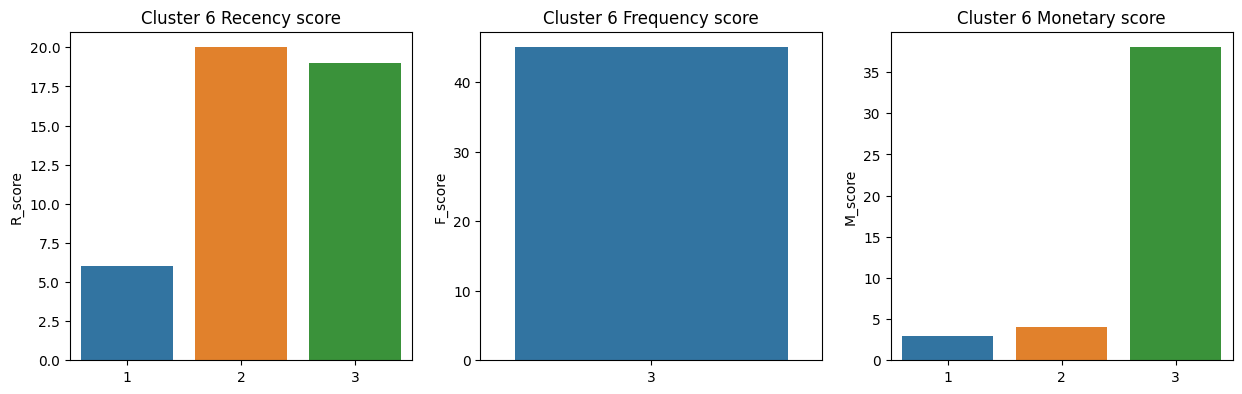

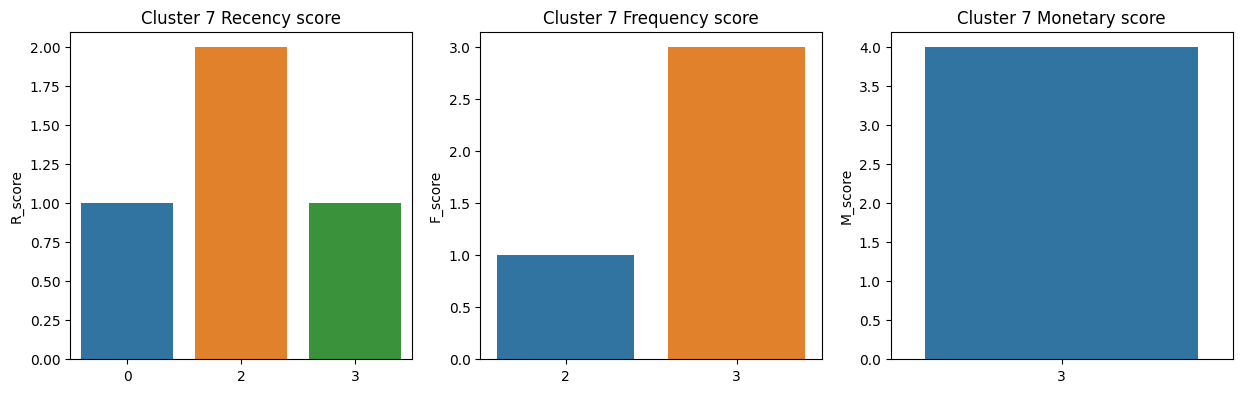

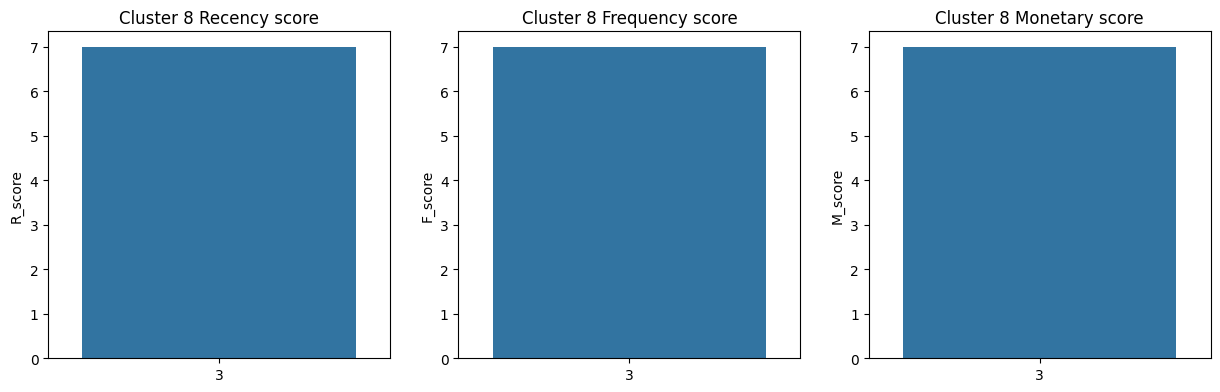

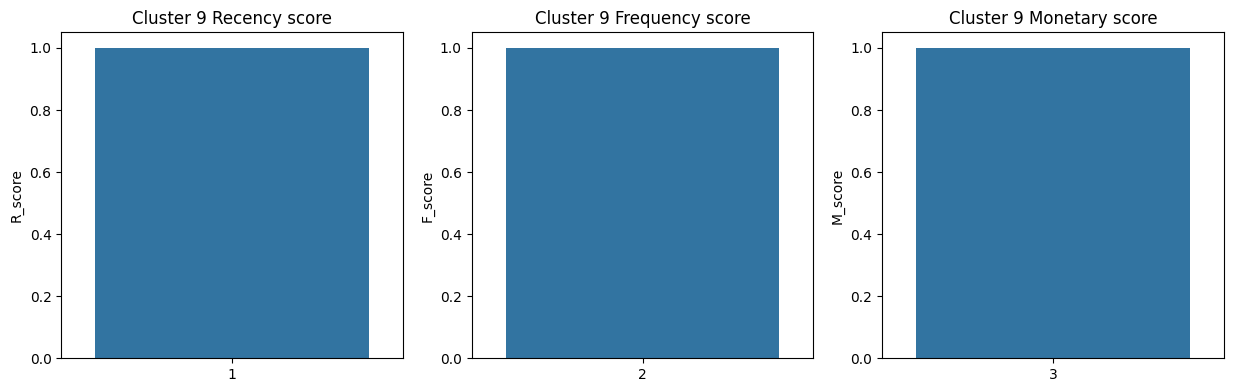

In [86]:
# frequency of scores(0, 1, 2 and 3) of recency, frequency and monetary in each cluster.
for n,i,a in zip(np.sort(data3["Cluster"].unique()),
                 range(1,len(data3["Cluster"].unique())+1),
                 range(5,(len(data3["Cluster"].unique())*5)+5,5)):
    plot_data=data5.get_group(n)
    plt.figure(figsize=(15,a))
    plt.subplot(i,3,1)
    sns.barplot(x=plot_data["R_score"].value_counts().index,y=plot_data["R_score"].value_counts())
    plt.title("Cluster"+" "+str(n)+" "+"Recency score")
    plt.subplot(i,3,2)
    sns.barplot(x=plot_data["F_score"].value_counts().index,y=plot_data["F_score"].value_counts())
    plt.title("Cluster"+" "+str(n)+" "+"Frequency score")
    plt.subplot(i,3,3)
    sns.barplot(x=plot_data["M_score"].value_counts().index,y=plot_data["M_score"].value_counts())
    plt.title("Cluster"+" "+str(n)+" "+"Monetary score")
    plt.show()

In [87]:
# here the customers were segmented by machine as well lets export this final segmented customers data
# and send it to the appropraiate users.
data3[["CustomerID","Loyalty","Segment","Cluster"]].to_csv("c:/users/lenovo/desktop/FinalCustomerSegment.csv")